# Choosing the best ramp profile

In [1]:
from pathlib import Path
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import pandas as pd

import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

import nemplot

from IPython.display import Image, display, HTML


In [20]:
DICT_LINES = 9
COLUMNS_TO_USE = 6

In [3]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [4]:
os.getcwd()

'C:\\Users\\Fabio\\code\\TeslaMax'

## Maps for K

In [27]:
def read_K_table(B_max,F_M):
    
    filename = "map_K_B_%d_FM_%d.txt" %(1e3*B_max,100*F_M)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with open(file_path) as f:
        flines = f.readlines()
        
    params = eval("".join(flines[0:DICT_LINES]))
    
    map_table = pd.read_csv(filename,sep='\s+',skiprows=DICT_LINES,usecols=range(0,COLUMNS_TO_USE),index_col=False)
    return map_table

In [29]:
K_map = read_K_table(1.25,0.4)
K_map

,R_o[mm],R_s[mm],phi_S[deg],n_II[],n_IV[],K[T^2]
0,40.0,100.0,35.0,1,2,4.964
1,40.0,100.0,35.0,1,3,4.640
2,40.0,100.0,35.0,1,4,4.497
3,40.0,100.0,35.0,2,2,4.951
4,40.0,100.0,35.0,2,3,4.619
5,40.0,100.0,35.0,2,4,4.494
6,40.0,100.0,35.0,3,2,4.952
7,40.0,100.0,35.0,3,3,4.622
8,40.0,100.0,35.0,3,4,4.481
9,40.0,100.0,45.0,1,2,2.186


In [31]:
table = K_map[K_map["R_s[mm]"] == 120]
table

,R_o[mm],R_s[mm],phi_S[deg],n_II[],n_IV[],K[T^2]
54,40.0,120.0,35.0,1,2,2.662
55,40.0,120.0,35.0,1,3,2.382
56,40.0,120.0,35.0,1,4,2.274
57,40.0,120.0,35.0,2,2,2.481
58,40.0,120.0,35.0,2,3,2.227
59,40.0,120.0,35.0,2,4,2.139


In [33]:
mp = table.pivot('n_II[]','n_IV[]','K[T^2]')

In [39]:
X=mp.columns.values
Y=mp.index.values
K=mp.values
n_IV, n_II =np.meshgrid(X, Y)

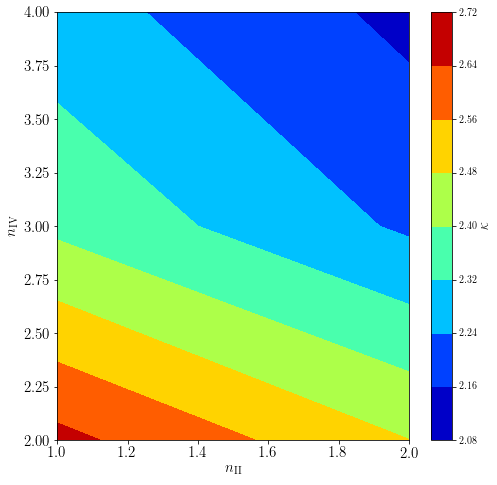

In [40]:
%matplotlib inline

fig, ax = nemplot.create_plot(xlabel=r'$n\ped{II}$',
                             ylabel=r'$n\ped{IV}$')

K_contour = ax.contourf(n_II,n_IV,K,cmap='jet')
K_colorbar = fig.colorbar(K_contour,ax=ax)
K_colorbar.set_label(r'$\mathcal{K}$')

In [42]:
table = K_map[K_map["n_II[]"] == 2]
table = table[table["n_IV[]"] == 3]
table

,R_o[mm],R_s[mm],phi_S[deg],n_II[],n_IV[],K[T^2]
4,40.0,100.0,35.0,2,3,4.619
13,40.0,100.0,45.0,2,3,1.923
22,40.0,100.0,55.0,2,3,1.807
31,40.0,110.0,35.0,2,3,3.476
40,40.0,110.0,45.0,2,3,0.933
49,40.0,110.0,55.0,2,3,0.946
58,40.0,120.0,35.0,2,3,2.227


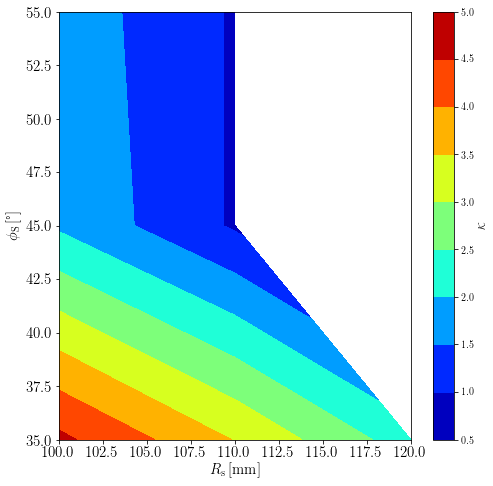

In [43]:
%matplotlib inline


mp = table.pivot('R_s[mm]','phi_S[deg]','K[T^2]')

X=mp.columns.values
Y=mp.index.values
K=mp.values
phi_S, R_s =np.meshgrid(X, Y)

fig, ax = nemplot.create_plot(xlabel=r'$R\ped{s}\,[\si{\mm}]$',
                             ylabel=r'$\phi\ped{S}\,[\si{\degree}]$')

K_contour = ax.contourf(R_s,phi_S,K,cmap='jet')
K_colorbar = fig.colorbar(K_contour,ax=ax)
K_colorbar.set_label(r'$\mathcal{K}$')